In [11]:
#import jax and other libraries for computation
import jax.numpy as jnp
from jax import jit
from jax.scipy.signal import convolve2d
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
from jax import tree_util
import numpy as np
#for visulization
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
# import AdoptODE
from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE
#import the MSD mechanics
from HelperAndMechanics import *

In [ ]:
# Load from HDF5
with h5py.File('../data/SpringMassModel/MechanicalData/data_eta_05_uvx.h5', 'r') as f:
    v = f['v'][:]
    u = f['u'][:]
    T = f['T'][:]
    x = f['x'][:]
    f.close()
N = T.shape[0]

In [ ]:
@jit
def distance_y(xy_grid):
    return (xy_grid[:,1:] - xy_grid[:,:-1])
@jit
def distance_x(xy_grid):
    return (xy_grid[:,:, 1:] - xy_grid[:,:, :-1])
@jit 
def distance_axial(xy_cm_grid,axial_grid):
    return (xy_cm_grid - axial_grid)     
@jit
def zero_out_edges(force):
        force = force.at[:,0, :].set(0)   # Top row
        force = force.at[:,-1, :].set(0)  # Bottom row
        force = force.at[:,:, 0].set(0)   # Left column
        force = force.at[:,:, -1].set(0)  # Right column
        return force
@jit
def force_field_struct(xy_grid,T,par):
    '''calculates the structural forces on the grid; enforces zero force on the edges
    input: shape (2, n, m) array of xy coordinates
    output: shape (2, n, m) array of forces'''

    #y-direction -> 
    #x-direction ^
    
    # x -- x -- x    
    # |    |    |
    # x -- x -- x    
    # |    |    |
    # x -- x -- x    
    l_g = jnp.full(xy_grid.shape, par['l_0'])
    # k_struct = jnp.full(xy_grid.shape, par['k_ij'])

    pad = int((xy_grid.shape[1]-T.shape[0]) / 2 )  # Pad the extended grid equally on all sides
    # Pad the extended grid equally on all sides


    d_y = distance_y(xy_grid)#points to the top
    d_x = distance_x(xy_grid)#points to the right

    # Apply padding on vertical distances
    d_y_upward = jnp.pad(d_y, ((0, 0), (1, 0), (0, 0)))  
    k_struct = jnp.full((1,T.shape[0],T.shape[1]+1), par['k_ij'])
    k_struct_pad= jnp.pad(k_struct, ((0,0), (pad, pad), (pad, pad)), mode="constant", constant_values=par['k_ij_pad'])
    k_y_upward = jnp.pad(k_struct_pad, ((0, 0), (1, 0), (0, 0)))

    d_y_downward = jnp.pad(d_y, ((0, 0), (0, 1), (0, 0)))  
    k_struct = jnp.full((1,T.shape[0],T.shape[1]+1), par['k_ij'])
    k_struct_pad = jnp.pad(k_struct, ((0,0), (pad, pad), (pad, pad)), mode="constant", constant_values=par['k_ij_pad'])
    k_y_downward = jnp.pad(k_struct_pad, ((0, 0), (0, 1), (0, 0)))

    # Apply padding on horizontal distances
    d_x_right = jnp.pad(d_x, ((0, 0), (0, 0), (1, 0))) 
    k_struct = jnp.full((1,T.shape[0]+1,T.shape[1]), par['k_ij'])
    k_struct_pad = jnp.pad(k_struct, ((0,0), (pad, pad), (pad, pad)), mode="constant", constant_values=par['k_ij_pad'])
    k_x_right = jnp.pad(k_struct_pad, ((0, 0), (0, 0), (1, 0)))
    
    d_x_left= jnp.pad(d_x, ((0, 0), (0, 0), (0, 1)))  
    k_struct = jnp.full((1,T.shape[0]+1,T.shape[1]), par['k_ij'])
    k_struct_pad = jnp.pad(k_struct, ((0,0), (pad, pad), (pad, pad)), mode="constant", constant_values=par['k_ij_pad'])
    k_x_left = jnp.pad(k_struct_pad, ((0, 0), (0, 0), (0, 1)))
   

    y_force_upward = k_y_upward*(l_g-jnp.linalg.norm(d_y_upward,axis = 0)) * d_y_upward/jnp.linalg.norm(d_y_upward,axis = 0) #force points to -y-direction
    y_force_downward = -k_y_downward*(l_g-jnp.linalg.norm(d_y_downward,axis = 0)) * d_y_downward/jnp.linalg.norm(d_y_downward,axis = 0) #force points to +y-direction
    x_force_left = -k_x_left*(l_g-jnp.linalg.norm(d_x_left,axis = 0)) * d_x_left/jnp.linalg.norm(d_x_left,axis = 0) #force points to -x-direction
    x_force_right = k_x_right*(l_g-jnp.linalg.norm(d_x_right,axis = 0)) * d_x_right/jnp.linalg.norm(d_x_right,axis = 0) #force points to +x-direction
    # print(d_y_upward/jnp.linalg.norm(d_y_upward,axis = 0))
    return zero_out_edges(y_force_upward+ y_force_downward+ x_force_left+ x_force_right)
@jit
def force_field_active(xy_grid,T,par):
    '''calculates the active forces on the grid; enforces zero force on the edges
    input: xy grid shape (2, size+2pad+1, size+2pad+1) array of xy coordinates
        T shape (size, size) array of electric signal
        enforces two lazers of same T outside the simulatio grid and pads the rest of the T values with 0
    output: shape (2, size+2pad+1, size+2pad+1) array of forces
        enforces zero force on the edges'''
    attachment_right, attachment_left = interpolate_active(xy_grid, par['n_0'])
    x_cm = center_of_mass_neighbors(xy_grid)
    
    #all distances point to the center of mass points
    d_act_right_to_bottom = distance_axial(x_cm, attachment_right)
    d_act_right_to_bottom = jnp.pad(d_act_right_to_bottom, ((0, 0), (0, 1), (1, 0)))
    d_act_right_to_top = distance_axial(x_cm, attachment_right)
    d_act_right_to_top = jnp.pad(d_act_right_to_top, ((0, 0), (1, 0), (1, 0)))  
    d_act_left_to_bottom = distance_axial(x_cm, attachment_left)
    d_act_left_to_bottom = jnp.pad(d_act_left_to_bottom, ((0, 0), (0, 1), (0, 1)))
    d_act_left_to_top = distance_axial(x_cm, attachment_left)
    d_act_left_to_top = jnp.pad(d_act_left_to_top, ((0, 0), (1, 0), (0, 1)))
    # pad electric signal 
    T_padded = enforce_T_and_pad(T, xy_grid)#shape (size+2pad, size+2pad)
    # initiate params
    k_active = jnp.full((1,T.shape[0]+2,T.shape[1]+2), par['k_a'])
    pad = int((xy_grid.shape[1]-k_active.shape[1]) / 2 )  # Pad the extended grid equally on all sides
    # Pad the extended grid equally on all sides
    k_active_pad = jnp.pad(k_active, ((0,0), (pad, pad), (pad, pad)), mode="constant", constant_values=par['k_a_pad'])
    l_a = jnp.full(T_padded.shape, par['l_0']/2)
    n = par['n_0']
    l_a_effective = l_a / (1+par['c_a']*T_padded)#shape (size+2pad, size+2pad)
    # Compute the spring forces acting on the grid; division by zero on the edges gets nan --> zero out edges in the end
    force_right_to_bottom = -(1-n) * jnp.pad(k_active_pad,((0, 0), (0, 1), (1, 0)))*(jnp.pad(l_a_effective,((0, 0), (0, 1), (1, 0)))-jnp.linalg.norm(d_act_right_to_bottom,axis = 0)) * d_act_right_to_bottom/jnp.linalg.norm(d_act_right_to_bottom,axis = 0) 
    force_right_to_top = -n * jnp.pad(k_active_pad,((0, 0), (1, 0), (1, 0))) *(jnp.pad(l_a_effective,((0, 0), (1, 0), (1, 0))) -jnp.linalg.norm(d_act_right_to_top,axis = 0)) * d_act_right_to_top/jnp.linalg.norm(d_act_right_to_top,axis = 0) 
    force_left_to_bottom = -n * jnp.pad(k_active_pad,((0, 0), (0, 1), (0, 1)))*(jnp.pad(l_a_effective,((0, 0), (0, 1), (0, 1)))-jnp.linalg.norm(d_act_left_to_bottom,axis = 0)) * d_act_left_to_bottom/jnp.linalg.norm(d_act_left_to_bottom,axis = 0)       
    force_left_to_top = -(1-n) * jnp.pad(k_active_pad, ((0, 0), (1, 0), (0, 1)))*(jnp.pad(l_a_effective, ((0, 0), (1, 0), (0, 1)))-jnp.linalg.norm(d_act_left_to_top,axis = 0)) * d_act_left_to_top/jnp.linalg.norm(d_act_left_to_top,axis = 0) 
    
    return zero_out_edges(force_right_to_bottom+force_right_to_top+force_left_to_bottom+force_left_to_top)
@jit
def force_field_passive(xy_grid,par):
    '''calculates the passive forces on the grid; enforces zero force on the edges
    input: shape (2, size+2pad, size+2pad) array of xy coordinates
    output: shape (2, size+2pad, size+2pad) array of forces
        enforces zero force on the edges'''
    attachment_top, attachment_bottom = interpolate_passive(xy_grid, par['n_0'])
    x_cm = center_of_mass_neighbors(xy_grid)
    d_pass_top_to_right = distance_axial(x_cm,attachment_top)
    d_pass_top_to_right = jnp.pad(d_pass_top_to_right, ((0, 0), (1, 0), (1, 0)))
    d_pass_top_to_left = distance_axial(x_cm,attachment_top)
    d_pass_top_to_left = jnp.pad(d_pass_top_to_left, ((0, 0), (1, 0), (0, 1)))
    d_pass_bottom_to_right = distance_axial(x_cm,attachment_bottom)
    d_pass_bottom_to_right = jnp.pad(d_pass_bottom_to_right, ((0, 0), (0, 1), (1, 0)))
    d_pass_bottom_to_left = distance_axial(x_cm,attachment_bottom)
    d_pass_bottom_to_left = jnp.pad(d_pass_bottom_to_left, ((0, 0), (0, 1), (0, 1)))
    # initiate params
    k_passive = jnp.full(xy_grid.shape, par['k_T'])
    l_p = jnp.full(xy_grid.shape, par['l_0']/2)
    n = par['n_0']
    
    # Compute the spring forces acting on the grid; division by zero on the edges gets nan --> zero out edges in the end
    force_top_to_right = -n * k_passive*(l_p-jnp.linalg.norm(d_pass_top_to_right,axis = 0)) * d_pass_top_to_right/jnp.linalg.norm(d_pass_top_to_right,axis = 0) 
    force_top_to_left = -(1-n) * k_passive*(l_p-jnp.linalg.norm(d_pass_top_to_left,axis = 0)) * d_pass_top_to_left/jnp.linalg.norm(d_pass_top_to_left,axis = 0)
    force_bottom_to_right = -(1-n) * k_passive*(l_p-jnp.linalg.norm(d_pass_bottom_to_right,axis = 0)) * d_pass_bottom_to_right/jnp.linalg.norm(d_pass_bottom_to_right,axis = 0)
    force_bottom_to_left = -n * k_passive*(l_p-jnp.linalg.norm(d_pass_bottom_to_left,axis = 0)) * d_pass_bottom_to_left/jnp.linalg.norm(d_pass_bottom_to_left,axis = 0)
    
    return zero_out_edges(force_top_to_right+force_top_to_left+force_bottom_to_right+force_bottom_to_left)
@jit
def center_of_mass_neighbors(xy_grid):
    '''calculates the center of mass for each block of 4 neighbors 
    input: shape (2, n, m) array of xy coordinates
    output: shape (2, n-1, m-1) array of xy coordinates'''
    x_coords = xy_grid[0, :, :]
    y_coords = xy_grid[1, :, :]
    
    # Calculate the center of mass for each block of 4 neighbors
    x_com = (x_coords[:-1, :-1] + x_coords[1:, :-1] + x_coords[:-1, 1:] + x_coords[1:, 1:]) / 4
    y_com = (y_coords[:-1, :-1] + y_coords[1:, :-1] + y_coords[:-1, 1:] + y_coords[1:, 1:]) / 4
    
    return jnp.stack([x_com, y_com], axis=0)
@jit
def interpolate_active(xy_grid, n):
    '''interpolates the active spring positions on the right and left walls
    input: shape (2, n, m) array of xy coordinates
    output: 2 arrays of shape (2, n-1, m-1) array of xy coordinates'''
    # Calculate vertical distance between neighboring points in the z-direction
    d_y = distance_y(xy_grid)

    # Compute the attachment point on the right wall using fraction n
    attachment_right = xy_grid[:, :-1, 1:] + n * d_y[:,:,1:]

    # Compute the attachment point on the left wall using fraction (1-n)
    attachment_left = xy_grid[:, :-1, :-1] + (1 - n) * d_y[:, :,:-1]

    # Return the x and z attachment points on the right and left walls respectively
    return attachment_right[:, :, :], attachment_left[:, :, :]
@jit
def interpolate_passive(xy_grid, n):
    '''Interpolates the active spring positions on the top and bottom walls.
    Input: shape (2, n, m) array of xy coordinates
    Output: 2 arrays of shape (2, n-1, m-1) array of xy coordinates'''
    
    d_x = distance_x(xy_grid)  # Compute horizontal distances

    # Top wall interpolation (fraction `n`)
    attachment_top = xy_grid[:, 1:, :-1] + (1 - n) * d_x[:, 1:, :]

    # Bottom wall interpolation (fraction `1 - n`)
    attachment_bottom = xy_grid[:, :-1, :-1] + n * d_x[:, :-1, :]

    return attachment_top, attachment_bottom
@jit
def enforce_T_and_pad(T, xy_grid):
    """Expands T by enforcing single-layer boundary values on left/right & top/bottom, then pads equally.
    
    Args:
        T: jnp.array of shape (size, size) (original simulation grid)
        xy_grid: Coordinates grid  of shape (2, size+2*pad+1, size+2*pad+1)
        pad: Total zero padding (added equally on all sides)
    
    Returns:
        jnp.array of shape (size + 2*pad, size + 2*pad)
    """
    i = 1
    # Enforce left and right boundaries using ONLY the first and last column (not two)
    left_extension = jnp.concatenate([T[:, i:i+1], T[:, i:i+1]], axis=1)  
    right_extension = jnp.concatenate([T[:, -i-1:i], T[:, -i-1:i]], axis=1)  
    T_extended_lr = jnp.concatenate([left_extension, T[:,i:-i], right_extension], axis=1)  
    # Enforce top and bottom boundaries using ONLY the first and last row (not two)
    top_extension = jnp.concatenate([T_extended_lr[i:i+1, :], T_extended_lr[i:i+1, :]], axis=0)  
    bottom_extension = jnp.concatenate([T_extended_lr[-i-1:-i, :], T_extended_lr[-i-1:-i, :]], axis=0)  
    T_extended_tb = jnp.concatenate([top_extension, T_extended_lr, bottom_extension], axis=0)  
    # Calculate the padding based on the difference between T size and xy_grid size
    # Assuming that xy_grid size should match the size of T, the padding calculation becomes simpler
    pad = int((xy_grid.shape[1]-T_extended_tb.shape[0]) / 2 )  # Pad the extended grid equally on all sides
    
    # Pad the extended grid equally on all sides
    T_padded = jnp.pad(T_extended_tb, ((pad, pad), (pad, pad)), mode="constant", constant_values=0)
    
    return jnp.reshape(T_padded, (1,T_padded.shape[0], T_padded.shape[1]))
def compute_dA(x, A_undeformed):
    """
    Computes the relative area change for a time series of quadrilateral meshes.

    Parameters:
    x : ndarray of shape (T, 2, H, M)
        Time series of x and y coordinate grids.
    A_undeformed : float
        The reference (undeformed) area.

    Returns:
    dA : ndarray of shape (T, H-1, M-1)
        The relative area change over time.
    """

    # Compute edge lengths (vectorized over time T)
    a = np.linalg.norm(x[:, :, 1:, 1:] - x[:, :, 1:, :-1], axis=1)  # Right edge
    b = np.linalg.norm(x[:, :, 1:, 1:] - x[:, :, :-1, 1:], axis=1)  # Top edge
    c = np.linalg.norm(x[:, :, :-1, 1:] - x[:, :, :-1, :-1], axis=1)  # Left edge
    d = np.linalg.norm(x[:, :, 1:, :-1] - x[:, :, :-1, :-1], axis=1)  # Bottom edge

    # Compute diagonal lengths
    diagonal1 = np.linalg.norm(x[:, :, :-1, 1:] - x[:, :, 1:, :-1], axis=1)  # Top-left to bottom-right
    diagonal2 = np.linalg.norm(x[:, :, 1:, 1:] - x[:, :, :-1, :-1], axis=1)  # Top-right to bottom-left

    # Compute helper term
    hlp = (b**2 + d**2 - a**2 - c**2)

    # Compute deformed area using the determinant formula
    A_deformed = np.sqrt(4 * diagonal1**2 * diagonal2**2 - hlp**2) / 4

    # Compute relative area change
    dA = A_deformed / A_undeformed - 1

    return dA

In [ ]:
def define_MSD(**kwargs_sys):
    # disc_x, disc_y = kwargs_sys['size'], kwargs_sys['size']
    dx, dy = kwargs_sys['spacing'], kwargs_sys['spacing']
    N_sys = kwargs_sys['N_sys']
    # padding = kwargs_sys['padding']

    def gen_params():
        return kwargs_sys['params_true'], {}, {}
    
    def gen_y0():
        return {'u':kwargs_sys['u0'],'v':kwargs_sys['v0'],'T':kwargs_sys['T0'],'x':kwargs_sys['x0'],'x_dot':kwargs_sys['x_dot0']}
    
    kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (dx * dy * 6)
    @jit
    def laplace(f):  #laplace of scalar
        f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
        f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
        return convolve2d(f_ext, kernel, mode='valid')
    @jit
    def epsilon(u,v,rp):
        return rp['epsilon_0']+rp['mu_1']*v/(u+rp['mu_2'])
    @jit
    def epsilon_T(u):
        return 1 - 0.9*jnp.exp(-jnp.exp(-30*(jnp.abs(u) - 0.1)))
    @jit
    def eom(y, t, params, iparams, exparams):
            
            par=params
            u=y['u']
            v=y['v']
            T=y['T']
            x=y['x']
            x_dot=y['x_dot']

            dudt = par['D']*laplace(u)-(par['k'])*u*(u-par['a'])*(u-1) - u*v
            dvdt = epsilon(u,v,par)*(-v-(par['k'])*u*(u-par['a']-1))
            dTdt = epsilon_T(u)*(par['k_T']*jnp.abs(u)-T)
            dx_dotdt = 1/par['m'] *  (force_field_active(x,T,par) +force_field_passive(x,par) + force_field_struct(x,T,par) - x_dot * par['c_damp'])#
            dxdt = x_dot
            return {'u':dudt, 'v':dvdt, 'T':dTdt, 'x':zero_out_edges(dxdt), 'x_dot':zero_out_edges(dx_dotdt)}
    @jit
    def loss(ys, params, iparams, exparams, targets):
        u = ys['u']
        u_target = targets['u']
        return jnp.nanmean((u - u_target)**2)  
            
    return eom, loss, gen_params, gen_y0, {}

In [ ]:
"""
    Reads in necessary parameters from config.ini
"""
N,size,params = read_config(['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
                             ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
                             'n_0','l_0','spacing'],mode = 'chaos')
keys =['D','a','k','epsilon_0','mu_1','mu_2','k_T','delta_t_e'
        ,'k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp',
        'n_0','l_0','spacing']
tol = 1
params_true = dict(zip(keys,params))
params_low = {key: value - value*tol for key, value in params_true.items()}
params_high = {key: value + value*tol for key, value in params_true.items()}

size = 100
pad = 10
delta_t_e = 0.08
sampling_rate = 10
length = 30#int(2000/sampling_rate)
t_evals = np.linspace(0, delta_t_e*sampling_rate*length, length)
u_fit = u[:length*sampling_rate][::sampling_rate,:,:]
T_fit = T[:length*sampling_rate][::sampling_rate,:,:]
v_fit = v[:length*sampling_rate][::sampling_rate,:,:]
x_fit = x[:length*sampling_rate][::sampling_rate,:,:,:]
x_dot = np.gradient(x,axis = 0)/delta_t_e
x_dot_fit = x_dot[:length*sampling_rate][::sampling_rate,:,:,:]

u0 = u_fit[0]
v0 = v_fit[0]
T0 = T_fit[0]
x0 = x_fit[0]
x_dot0 = x_dot_fit[0]

# #new initial conditions
# u0 = jnp.zeros_like(u_fit[0])
# v0 = jnp.zeros_like(v_fit[0])
# T0 = jnp.zeros_like(T_fit[0])
# x_dot0 = jnp.zeros_like(x_dot_fit[0])
# # Create a 100x100 grid of x and z coordinates
# size = 100
# pad = 10
# size_mech = size + 2*pad +1
# x_vals = np.linspace(0, size_mech-1,size_mech)
# z_vals = np.linspace(0, size_mech-1,size_mech)
# # Generate meshgrid for x and z
# x_grid, z_grid = np.meshgrid(x_vals, z_vals)
# xy_grid = jnp.array([x_grid, z_grid])
# x0 = xy_grid
# print(x0.shape)

targets = {'u':u_fit.reshape(1,length,100,100),'v':v_fit.reshape(1,length,100,100),'T':T_fit.reshape(1,length,100,100),'x':x_fit.reshape(1,length,2,size+2*pad+1,size+2*pad+1)}
kwargs_sys = {'size': 100,
              'spacing': 1,
              'N_sys': 1,
              'params_true': params_true,
              'u0': u0,'v0': v0,'T0': T0,'x0': x0,'x_dot0': x_dot0}
kwargs_adoptODE = {'epochs': 10,'N_backups': 1,'lr': 1e-3,'lower_b': params_low,'upper_b': params_high,
                   'lower_b_y0':{'u':u0,'v':v0,'T':T0,'x':x0,'x_dot':x_dot0},
                    'upper_b_y0':{'u':u0,'v':v0,'T':T0,'x':x0,'x_dot':x_dot0}}

In [ ]:
# Setting up a dataset via simulation
Simulation_MSD = simple_simulation(define_MSD,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE)
x_sim = Simulation_MSD.ys['x'][0]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
dA_sim = compute_dA(x_sim, 1)
dA_fit = compute_dA(x_fit, 1)
print(dA_sim.shape)
T_sim = Simulation_MSD.ys['T'][0]

vmin,vmax =  -.2,.2
# Function to update the plot
# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(dA_fit[frame, :, :], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"dA ground trouth")
    
    # Plot dA_sim
    im2 = axes[1].matshow(dA_sim[frame, :, :], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"dA simulation")
    
    # Add colorbars
    fig.colorbar(im1, ax=axes[0])
    fig.colorbar(im2, ax=axes[1])

    plt.show()

    # cbar.set_clim(vmin, vmax)  # Explicitly set colorbar limits

    # # Plot original grid points
    # ax.scatter(x_fit[frame, 0, :, :], x_fit[frame, 1, :, :], color='blue', marker='x', label='Original Grid', s=10)
    # ax.set_title(f"Attachment Points on Left and Right Walls (n = {params_true['n_0']}, Frame {frame})")
    # ax.set_xlabel("X")
    # ax.set_ylabel("Z")
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.grid(True)
    
    # plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=x_sim.shape[0]-1, step=1, value=0, description="Frame")

# Display interactive plot
widgets.interactive(update_plot, frame=frame_slider)


(30, 120, 120)


interactive(children=(IntSlider(value=0, description='Frame', max=29), Output()), _dom_classes=('widget-intera…

(100, 100) (2, 121, 121)
(120, 120)
(100, 100)


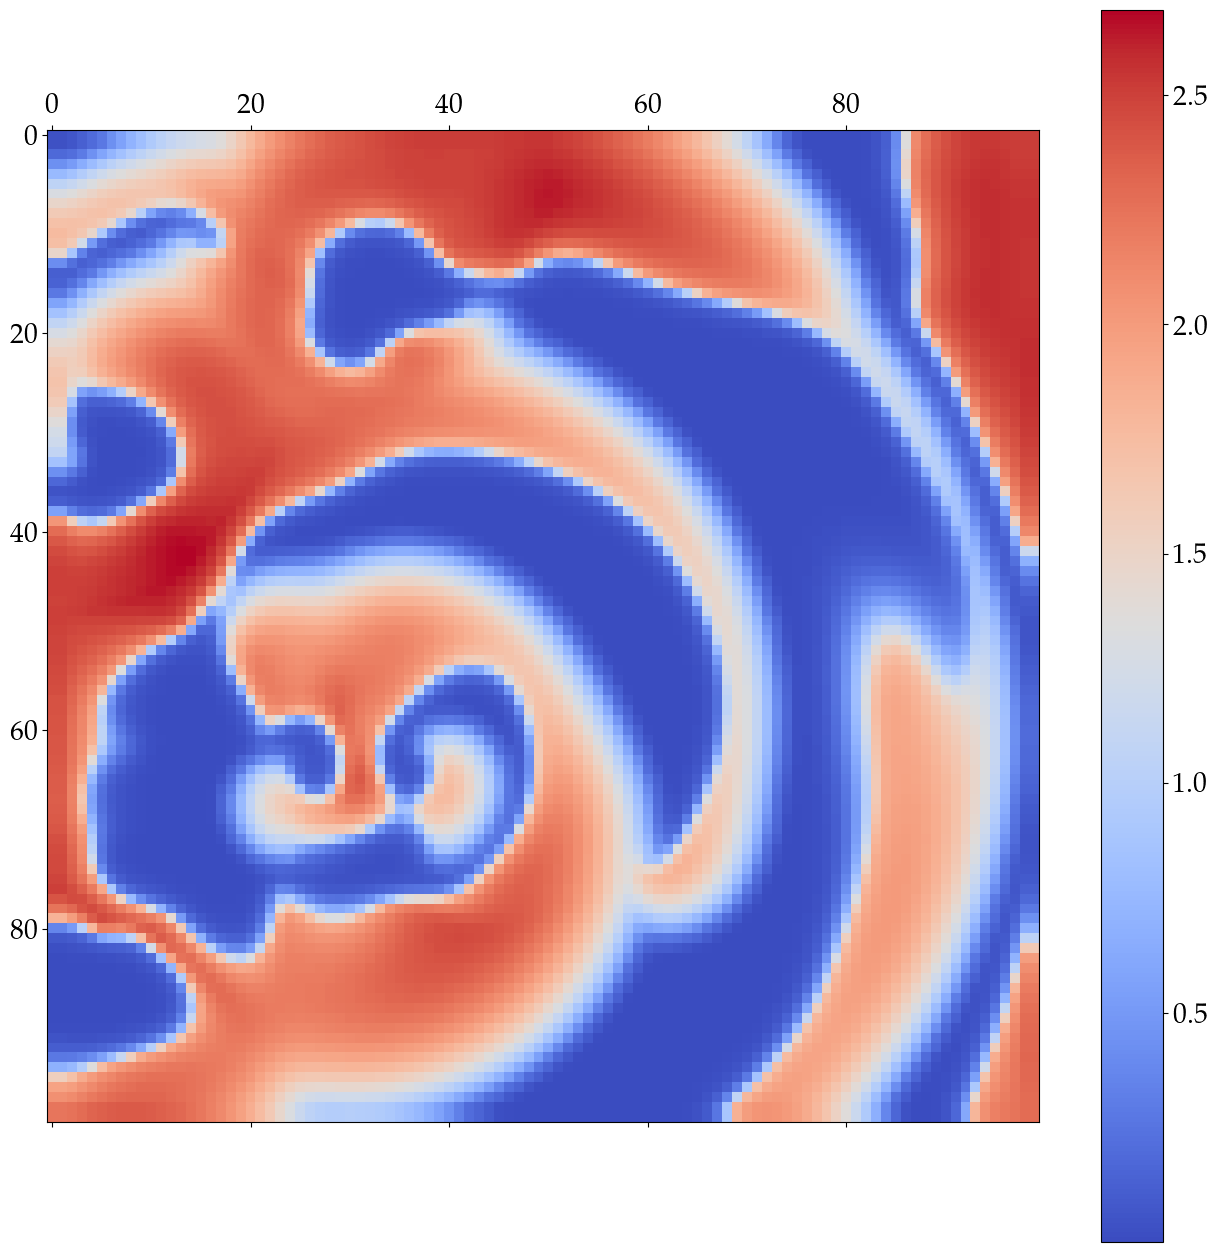

In [ ]:
print(T[0].shape,x_sim[0].shape)
T_test = enforce_T_and_pad(T[0], x_sim[0])[0]
print(T_test.shape)
#plot heatmap of dA[0,:,:]
pad = 10
print(T_test[pad:-pad,pad:-pad].shape)

fig, ax = plt.subplots(figsize=(16, 16))
cax = ax.matshow(T[100,:,:], cmap='coolwarm')
# cax = ax.matshow(T_test[pad:-pad,pad:-pad], cmap='coolwarm')
fig.colorbar(cax)
plt.show()